![alt text](https://whylabs-public.s3.us-west-2.amazonaws.com/assets/whylabs-logo-night-blue.svg)

*Run AI with Certainty*

# **Using WhyLabs with Sagemaker** 

Before starting, you'll need a few things.
- An AWS role that can be used as the a Sagemaker execution role.
- An S3 bucket for uploading the model, and custom inferencey.py to.
- A free [WhyLabs account](https://hub.whylabsapp.com/) and your WhyLabs API key, dataset id from the settings menu.

The integration works by leveraging a custom `inference.py` file for a Sagemaker deployment via the Sagemaker SDK. This example uses a pytorch model, but the other types of Sagemaker models sometimes have different interfaces for their `inference.py` files, so this may not be compatible with their TensorFlow model deployment verbatim, though the concepts will apply.

We'll be creating a rolling whylogs logger in a dedicated process on the Sagemaker deployment that will asynchronously log all of the data you send, and periodically upload those generated whylogs profiles to WhyLabs.


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whylabs/whylogs/blob/mainline/python/examples/integrations/sagemaker_whylabs_example/pytorch-sagemaker.ipynb)

In [ ]:
%pip install sagemaker whylogs torch torchvision

## AWS Authentication

Set up the AWS authentication by preparing an execution role for Sagemaker and ensuring you can use the aws cli.

In [2]:
import sagemaker
from sagemaker.pytorch import PyTorchModel

# A sagemaker execution role that you previously created
aws_role = "YOUR_AWS_ROLE"
aws_region = "us-west-2"
session = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/xdg-gnome/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/anthony/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/xdg-gnome/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/anthony/.config/sagemaker/config.yaml


## Prepare model
For this example we'll package up an existing model, one of the resnet variants available in pytorch.

In [3]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
import tarfile

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.eval()

model_file_name = "resnet.pt"
model_archive_name = "model.tar.gz"

traced_script_module = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_script_module.save(model_file_name)

# Then, compress it into a tar.gz file
with tarfile.open(model_archive_name, "w:gz") as tar:
    tar.add(model_file_name)


bucket = 'YOUR_BUCKET_NAME'
key_prefix = 'sagemaker_models/resnet50-3'

upload_path = session.upload_data(path='model.tar.gz', bucket=bucket, key_prefix=key_prefix)
# int(f"Model artifact uploaded to: {upload_path}")

## Prepare the requirements file
You'll need to install whylogs on the Sagemaker host. You do this by passing a requirements file with everything that you need. We'll create a dummy virtual env here just to export a requirements file for Sagemaker. 

In [ ]:
! mkdir -p code 
! bash -c "virtualenv ./code/.venv && source ./code/.venv/bin/activate && pip install whylogs[image,proc]==1.3.8 && pip freeze > code/requirements.txt"
! rm -rf ./code/.venv

## Create an inference.py file
The integration happens in the custom inference logic for the Sagemaker container. The important parts are captured below.  This cell will be written to a file and deployed along with the model further down. This happens to be logging image data but it works with other kinds of data as well.

In [ ]:
%%writefile code/inference.py
import traceback
import torch
import requests
import json

import whylogs as why
from whylogs.api.logger.experimental.logger.actor.process_rolling_logger import ProcessRollingLogger
from whylogs.api.logger.experimental.logger.actor.time_util import Schedule, TimeGranularity
from whylogs.extras.image_metric import init_image_schema


# Initialize whylogs with your WhyLabs API key and target dataset ID. You can get an api key from the
# settings menu of you WhyLabs account.
why.init(whylabs_api_key="YOUR_API_KEY", default_dataset_id="model-xx")
row_name = "image"


def create_logger():
    logger = ProcessRollingLogger(
        # This should match the model type in WhyLabs. We're using a daily model here.
        aggregate_by=TimeGranularity.Day,
        # The profiles will be uploaded from the rolling logger to WhyLabs every 5 minutes. Data
        # will accumulates during that time.
        write_schedule=Schedule(cadence=TimeGranularity.Minute, interval=5),
        schema=init_image_schema(row_name),  # Enables image metrics
    )

    logger.start()
    return logger


# Utility function for converting our resnet class predictions into english.
def create_class_names():
    url = "https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt"
    response = requests.get(url)
    class_names = response.text.split("\n")
    return {i: class_names[i] for i in range(len(class_names))}


class_names = create_class_names()
logger = create_logger()


def model_fn(model_dir):
    model = torch.jit.load(f"{model_dir}/resnet.pt")
    return model


def input_fn(request_body, request_content_type):
    assert request_content_type == 'application/json'
    body = json.loads(request_body)

    if 'flush' in body and body['flush']:
        # Utility for flushing the logger, which forces it to upload any pending profiles synchronously.
        logger.flush()
        return None


    if 'close' in body and body['close']:
        logger.close()
        return None

    # We're going to be uploading the preprocessed and original images to sagemaker for this example
    # to avoid having to deploy torchvision. We don't want to log the preprocessed image, just the actual one.
    assert 'image' in body
    assert 'raw_img' in body

    try:
        # Log image async with whylogs. This won't hold up predictions.
        data = body['raw_img']
        print(f'logging type {type(data)} {type(data[0][0][0])}')
        logger.log({row_name: data})  
    except Exception as e:
        print(f"Failed to log image: {e}")
        print(traceback.format_exc())

    return torch.tensor(body['image'], dtype=torch.float32)


def predict_fn(input_tensor: torch.Tensor, model: torch.nn.Module):
    if input_tensor is None:
        return ""

    img_batch = torch.unsqueeze(input_tensor, 0)
    with torch.no_grad():
        output_tensor = model(img_batch)

    _, predicted_class = torch.max(output_tensor, 1)
    predicted_label = class_names[float(predicted_class.numpy())]
    return predicted_label


def output_fn(prediction, content_type):
    return str(prediction)


# Create a pytorch deployment

In [ ]:
sagemaker_model = PyTorchModel(
    source_dir='code',
    entry_point='inference.py',
    model_data=upload_path,
    framework_version='2.0',
    py_version='py310',
    role=aws_role,
)

In [ ]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import StringDeserializer

predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')
predictor.serializer = JSONSerializer()
predictor.deserializer = StringDeserializer()

# Make predictions

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import numpy as np

preprocess = ResNet50_Weights.DEFAULT.transforms()

def open_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.show()
    return img

def predict(image):
    img_transformed = preprocess(image).tolist() # preprocessed data for the model
    img_list = np.asarray(image).tolist() # original image data
    return predictor.predict({'image':img_transformed, 'raw_img':img_list}, initial_args={'ContentType': 'application/json'})

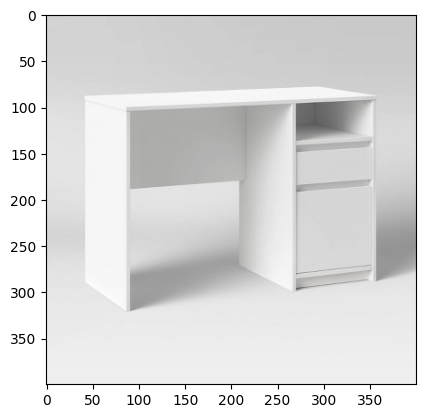

'desk'

In [9]:
img = open_image("https://guest-session-testing-public.s3.us-west-2.amazonaws.com/images/desk.jpeg")
predict(img)

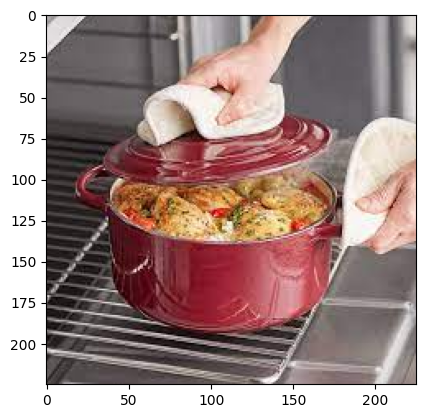

'Dutch oven'

In [10]:
img = open_image("https://guest-session-testing-public.s3.us-west-2.amazonaws.com/images/dutch_oven.jpeg")
predict(img)

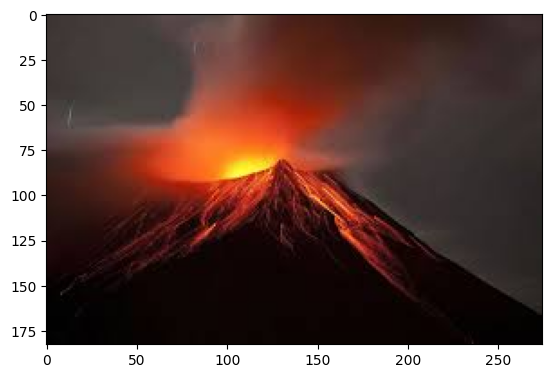

'volcano'

In [11]:
img = open_image("https://guest-session-testing-public.s3.us-west-2.amazonaws.com/images/volcano.jpeg")
predict(img)

## Force the logger to upload

> ⚠️ These things really only reliably work if you have a single instance behind your prediction endpoint. Otherwise you'll have to make sure these requests get to each endpoint individually. Without this, you might lose the last 5 minutes of data if Sagemaker shuts down without giving whylogs a chance to upload data.

This forces the logger to upload (see the inference.py code) which uploads any remaining data in the logger before we close down the Sagemaker endpoint. The rolling logger typically uploads data on a predefined interval so you can do something like this to make sure you don't clip your profile uploads before shutting things down. Sagemaker doesn't provide any "on close" hooks to make this transparent.


In [12]:
predictor.predict({'flush':True}, initial_args={'ContentType': 'application/json'})

''

In addition, you can close the logger. This also forces an upload but results in the logger no longer being active, so you should only do this before you're about to tear down the endpoint since it let's you synchronously wait for any pending uploads to finish.

Remember, these don't automatically work. They only work because we set up the `inference.py`` file to check for these payloads and call the right methods on the logger.

In [13]:
predictor.predict({'close':True}, initial_args={'ContentType': 'application/json'})

''

# Clean up endpoint

In [14]:
predictor.delete_endpoint()